[View in Colaboratory](https://colab.research.google.com/github/MicroprocessorX069/Prediction-of-Page-Rank/blob/master/LeToR_Regression_and_Gradient_Descent_Basics.ipynb)

In [0]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [0]:
maxAcc = 0.0 #maximum Accuracy
maxIter = 0 #maximum Iteration
Lambda_array = [0,0.01,0.02,0.03,0.05,0.1,1.0,5.0,1000.0,10000000000.0] #Regularizer
TrainingPercent = 80 
ValidationPercent = 10
TestPercent = 10
numberBasisFn = [1,5,10,25,50]  #Number of basis function.
PHI = []
IsSynthetic = False

In [0]:
def GetTargetVector(filePath):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

def GenerateRawData(filePath, IsSynthetic):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1)
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix

#Subsetting Training target values  acc. to training percent
def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

#Subsetting Training input features' values  acc. to training percent
def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

#Subsetting Validation input features' values  acc. to training percent
def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

#Subsetting Validaiton Target values  acc. to training percent  
def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
  # To calculate BigSigma as
  #BigSigma 41 x 41
  #Matrix of variances between input features, to calculate PhiMatrix
    '''
                          x(1)      x(2)      x(3) .  .  .     x(41)
    BigSigma =   x(1)  Var(1,1)      0         0                 0

                 x(2)       0      Var(2,2)    0                 0

                 x(3)       0       0        Var(3,3)            0
                  .
                  .
                  .
                 x(41)                                      Var(41,41)
      '''        
    
    #Initializing BigSigma matrix as zeros since we just have to populate the diagonal elements
    
    BigSigma    = np.zeros((len(Data),len(Data))) #shape = 41,41
    DataT       = np.transpose(Data) #len(DataT)=69k 
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01)) #math ceil return smallest integer less than X, basically converting to nearest bigger int #Len of training data set = 80% of 69k ~ 67k 
    varVect     = []
    
    # Calculating the variance for each input feature, based on training data. np.var return variance of an array
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct)) #Varianance of Data[i,;] i.e. input feature i
    
    #Populating BigSigma Matrix
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j] ## All other indices other than j,j (i.e. where i != j) would be zero since the covariance between two input features is no required.
    if IsSynthetic == True:         # Use of isSynthetic not known yet
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    #Converts the matrices' (x-Mu), BigSigmaInverse, (x-Mu) product to scalar
    
    #R is (x-Mu); Shape : 1 x 41
    R = np.subtract(DataRow,MuRow)
    #np.transpose(R) is Transpose of (x-Mu); Shape :  41 x 1
    # Shape of BigSigInv is 41 x 41
    # Therefore Shape of T i.e. (R x BigSigmaInverse x Inv(R)): (41) x 41) . (41 x 1)
    #                                                          : 41 x 1 
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T) #(R . T)
    # Therefore Shape of T i.e. (R x BigSigmaInverse x Inv(R)): (1 x 41). (41) x 41) . (41 x 1)
    #                                                          : 1 x 1 # HenceScalaar
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):  
  #Calculation of Phi(x)
  #Vector Phi(x) = (-0.5 . (x-Mu) . BigSigmaInverse . (x-Mu))
   #              e
    # math.exp is exponential function e^(x) where x is the argument of the function
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    #Phi Matrix Shape:  No. of basis fns x Dataset_height i.e. 10 x 67k
    # 10 Basis function matrix applied on 41 input feautres
    '''
    #Phi(x(1)(1/10)) Means Basis function of 1/10 th part of input feature 1 (We divided the input features with kmeans below into 10 clusters)
    
    Vector Phi(x) = (-0.5 . (x-Mu) . BigSigmaInverse . (x-Mu))
                   e
                   
                   
                        Phi1                   Phi2                     Phi3                    .  .  .     Phi10    # no of basis functions i.e. 10
  PhiMatrix=   x(1)   Phi(x(1)(1/10))      Phi(x(1)(2/10))         Phi(x(1)(3/10))     .  .  .        Phi(x(1)(10/10))
  
               x(2)   Phi(x(2)(1/10))      Phi(x(2)(2/10))         Phi(x(2)(3/10))     .  .  .        Phi(x(2)(10/10))
    
               x(3)   Phi(x(3)(1/10))      Phi(x(3)(2/10))         Phi(x(3)(3/10))     .  .  .        Phi(x(3)(10/10))
                .
                .
                .
              x(67k)  Phi(x(67k)(1/10))    Phi(x(67k)(2/10))       Phi(x(67k)(3/10))     .  .  .      Phi(x(67k)(1/10))
    '''        
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    
    # Calculating inverse of BigSigma matrix for the formula of phi
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            #Calculating Phi of each x1
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda):
   
    #Closed form of weights: PhiInv(x) . TargetValues
#                           [ Inverse(TransposePhi(x). Phi(x) + Lambda). TransposePhi(x) ] . Target values  # Moore Penrose Pseudo inverse
    
    #Lambda_I is bias
    # Vectorizing Lambda as identity matrix of shape of phi matrix.  
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI) #TransposePhi(x)
    PHI_SQR     = np.dot(PHI_T,PHI) # TransposePhi(x).Phi(x)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR) # TransposePhi(x). Phi(x) + Lambda
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI) # Inverse(TransposePhi(x). Phi(x) + Lambda). TransposePhi(x)
    INTER       = np.dot(PHI_SQR_INV, PHI_T) #  [ Inverse(TransposePhi(x). Phi(x) + Lambda). TransposePhi(x) ]
    W           = np.dot(INTER, T) # [ Inverse(TransposePhi(x). Phi(x) + Lambda). TransposePhi(x) ] . Target values 
    ##print ("Training Weights Generated..")
    return W

#Generating Phi Matrix. Overview/Main Function
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) #len(muMatrix) is no. of basis functions
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

# GetValTest Gives output Values for Validation Test Data. Val_Phi is the basis funcion matrix of Validation input features. and W is the weights 
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y


# VAL_TEST_OUT are Output values of Validation Test data. 
# ValDataAct are the Target Values of Validation Test Data
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    error=[]
    # sum of sqaure mean error
    # E= Summation( Target Values - Output Values )^2
    for i in range (0,len(VAL_TEST_OUT)):
        error.append(math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2))
        sum = sum + error[i]
        
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]): # np.around rounds to the nearest no. of decimals
            counter+=1 # Counting no. of correctly predicted values in validation test data 
    Mean=sum/len(VAL_TEST_OUT)
    Erms=pow(Mean,0.5)
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT))) # Accuracy of correctly predicted values by total no of prediction.
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return(Erms)
    #return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [5]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv') #Reads Querylevelnorm_t.csv (Target values) as list. 
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic) #Reads Querylevelnorm_X.csv (Input feature values) as list. 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


In [8]:
RawData.shape

(41, 69623)

## Prepare Training, Validation and Test Data

In [9]:
#Training data is strictly used for training the model
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent)) #Training Target data #GenerateTrainingTarget is function to subset RawTarget data according to TrainingPercent
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent) #Training Input features
print(TrainingTarget.shape)
print(TrainingData.shape)

#Validation is held out from the training dataset itself for unbiased evaluation of model trained on training data.
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget)))) #Validation Target data
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget))) # Validation Input features
print(ValDataAct.shape)
print(ValData.shape)

#Test data is new data for evaluation of final model
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct)))) #Testing Target values
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct))) #Testing input features
print(TestDataAct.shape)
print(TestData.shape)

(55699,)
(41, 55699)
(6962,)
(41, 6962)
(6961,)
(41, 6961)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

## Finding Erms on training, validation and test set 

In [10]:
print ('UBITname      = vineetsu')
print ('Person Number = 50291159')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = 10 \nLambda = 0.9")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

UBITname      = vineetsu
Person Number = 50291159
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.9


NameError: ignored

0 0 0.6402356058182178
0 1 0.6311326201100065
0 2 0.6278318457308204
0 3 0.6225888412815104
0 4 0.6182488986010921
1 0 0.6402356135332975
1 1 0.6311324222125647
1 2 0.6278937255791303
1 3 0.6232806660210468
1 4 0.6192380545215237
2 0 0.6402356212483803
2 1 0.6311322247304666
2 2 0.6279412477129425
2 3 0.62378956612006
2 4 0.6195063061309675
3 0 0.6402356289634681
3 1 0.6311320276632683
3 2 0.6279788453854207
3 3 0.6241635963142228
3 4 0.6197176342832292
4 0 0.6402356443936523
4 1 0.6311316347717643
4 2 0.6280345564772899
4 3 0.6246954095405635
4 4 0.6200607787657946
5 0 0.6402356829691718
5 1 0.6311306597723483
5 2 0.6281151520215628
5 3 0.6254862541041986
5 4 0.6207069259088349
6 0 0.6402363773433518
6 1 0.6311148159158593
6 2 0.6282247341562314
6 3 0.6277574313707361
6 4 0.624753422306319
7 0 0.6402394637898843
7 1 0.6310775032701786
7 2 0.6282112851327438
7 3 0.628219698617478
7 4 0.6272300120556903
8 0 0.6410233028780147
8 1 0.6377555818495683
8 2 0.63525689415425
8 3 0.63222247408

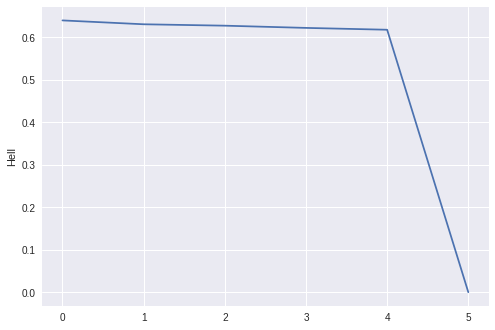

In [50]:
import numpy as np
import time
start=time.time()
TestAcc=np.zeros((len(Lambda_array)+1,len(numberBasisFn)+1))
d,e=0,0
for C_Lambda in Lambda_array:
  e=0
  for M in numberBasisFn:
    ErmsArr = [] #ERMS error for each x(i) in validation 
    AccuracyArr = [] 

    #Dividing the data of 69K into 10 clusters
    kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
    Mu = kmeans.cluster_centers_ #Creating centres for each of FEATURES . Feature one would have 10 clusters of 69k data values divided into it and so on.

    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic) # generating variance for each input feature
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)

    # Closed form of weights: PhiInv(x) . TargetValues
    #                        [ Inverse(TransposePhi(x). Phi(x)+ Lambda). TransposePhi(x) ] . Target values  # Moore Penrose Pseudo inverse
    # Shape of Phi(x) : 58k x 10
    # Shape of TransposePhi(x) : (10 x 58k)
    # Shape of Lambda(vector) : 10 x 10
    # Shape of Inverse(TransposePhi(x). Phi(x)) : 10 x 10
    # Shape of Inverse(TransposePhi(x). Phi(x)). TransposePhi(x) : (10 x 10) . (10 x 58k)
    #                                                              (10 x 58 k)                      
    # Shape of Target Values:(58k x 10)
    # Therefore  Shape of Weights : 10 x 10
    W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

    #TR_TEST_OUT, VAL_TEST_OUT, TEST_OUT  are the training, validation and test outputs generated for their respective Input features.
    # Generating output = W x Input features
    #                     W x Phi(x)    W is generated while Training data.
    TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
    VAL_TEST_OUT = GetValTest(VAL_PHI,W)
    TEST_OUT     = GetValTest(TEST_PHI,W)

    #Root mean square method of accuracy used (Erms) 
    #E= Summation( Target Values - Output Values )^2
    TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget)) # Training Accuracy
    ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct)) # Validation Accuracy
    TestAccuracy       = (GetErms(TEST_OUT,TestDataAct)) #Testing Accuracy
    print(d,e,TestAccuracy)
    TestAcc[d,e]=TestAccuracy
    e=e+1
  d=d+1

import matplotlib.pyplot as plt
plt.plot(TestAcc[0])
plt.ylabel('Hell')
plt.show()
end=time.time()
time_taken=end-start

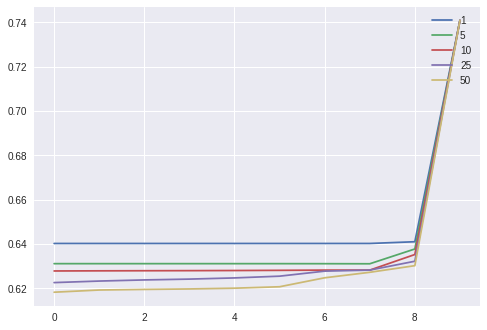

In [69]:
#plt.ylim(0.6,0.66)
plt.plot(TestAcc[0:10,0])
plt.plot(TestAcc[0:10,1])
plt.plot(TestAcc[0:10,2])
plt.plot(TestAcc[0:10,3])
plt.plot(TestAcc[0:10,4])
plt.legend([1,5,10,25,50], loc='upper right')

plt.show()

In [40]:
plt.plot(TestAcc[:,4])


[2660.71486803 2669.23560221 2671.54870888 2673.37167579 2676.33304614
 2681.91380867 2716.99551408 2738.57913413 2764.76303357 3820.67897268
    0.        ]


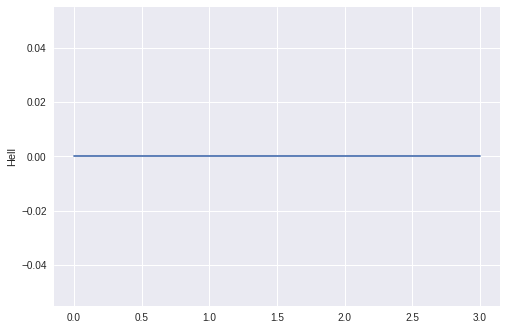

In [35]:
import matplotlib.pyplot as plt
plt.plot(TestAcc[3])
plt.ylabel('Hell')
plt.show()

In [15]:
W
#np.dot(220, W)

array([-8.75436103,  2.00457373, -0.459161  , -4.10971613,  0.68071942,
        1.64717812,  0.78392423,  5.58744107,  2.68438131,  0.54812689])

## Gradient Descent solution for Linear Regression

In [0]:
#Stochastic Gradient Decent.
# Creating parts of the dataset and training separartely.
W_Now        = np.dot(220, W) # why 220? 
La           = 2 
learningRate = 0.01 #learning rate is Size of Steps taken to reach to the minimum of error. Bigger the step, more chances of missing the minimum.
L_Erms_Val   = [] 
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

#
for i in range(0,400):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now)
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [13]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.54964
E_rms Validation = 0.53846
E_rms Testing    = 0.62372
